In [20]:
from google.colab import drive
drive.mount('/content/drive')

#loading the dataset and extracting from the zip file
!unzip drive/My\ Drive/2000_fold2_new.zip
#installing relevent modules for resnet34 model
!pip install git+https://github.com/qubvel/classification_models.git

!unzip drive/My\ Drive/Test_2000_new.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/My Drive/2000_fold2_new.zip
replace __MACOSX/._2000_fold2_new? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N
N
n
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-t1i0ghzz
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-t1i0ghzz
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20032 sha256=448d0c59e5e70f1bcc0c88e126a3d1d997bb61142e22115b3b18dde021401137
  Stored in directory: /tmp/pip-ephem-wheel-cache-wwl48_vs/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers
Archive:  drive/My Drive/Test_2000_new.zip
replace __MACOSX/._Test_2000_new? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N
N


In [1]:
#related modules 
import keras
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from classification_models.keras import Classifiers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,auc
from sklearn.metrics import average_precision_score
import tensorflow as tf
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
import os
import glob
import pandas as pd
from fnmatch import fnmatch

In [2]:
train_path = "/content/2000_fold2_new/Train"
val_path = "/content/2000_fold2_new/Validation"
test_path ="/content/Test_2000_new"

batch_size = 32

loss_function ='categorical_crossentropy'
patience = 10
epoch = 50
final_activation ='softmax'
file_pattern = "*.jpg"
folder_pattern = "*TCGA-*"


Resnet34_model,preprocess_input = Classifiers.get('resnet34')
base_model = Resnet34_model(input_shape=(224,224,3), weights='imagenet', include_top=False)

#reading train and validation data
data_generator = ImageDataGenerator(rescale = 1./255,preprocessing_function=  preprocess_input)
#loop and iterating through train images
train_data_generator = data_generator.flow_from_directory(train_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle =True)
#iterating through images of validation set
val_data_generator = data_generator.flow_from_directory(val_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle = True)
#class wight balance

#class wight balance
# classes = train_data_generator.classes
class_weights_list = class_weight.compute_class_weight('balanced',np.unique(train_data_generator.classes),train_data_generator.classes)
weights = dict(zip(np.unique(train_data_generator.classes),class_weights_list))
print("weights ratio to make the dataset balanced: ",weights)

print("class Indices of train generator :",train_data_generator.class_indices)
print("class Indices of validation generator :",val_data_generator.class_indices)

Found 118100 images belonging to 2 classes.
Found 29602 images belonging to 2 classes.
weights ratio to make the dataset balanced:  {0: 0.6483880885453268, 1: 2.1847713482314637}
class Indices of train generator : {'Epithelioid': 0, 'Nonepithelioid': 1}
class Indices of validation generator : {'Epithelioid': 0, 'Nonepithelioid': 1}


In [3]:
model_new = base_model.output
model_new = Flatten(name="flatten")(model_new)
model_new = Dense(2, activation="softmax")(model_new)

#this function takes the each patch in WSI then predicts the probability score
def pred_each_patch(path,name):
    y = image.load_img(os.path.join(path, name))
    img = image.img_to_array(y)
    y = np.expand_dims(img, axis = 0)
    y = preprocess_input(y)
    y /= 255
    y_pred = model.predict(y)
    return y_pred
        
def avg(predlist):
    average = sum(predlist)/len(predlist)
    return average

def extract_index_one_frmpred(prediction_list):               
    ypred = np.stack(prediction_list)#we are vertically stacking the predictions
    ypred = np.reshape(ypred, [len(prediction_list),2])#reshaping to 100,2 - np array
    for each in ypred:
    #after reshaping the predictions as we wanted, we are taking the index '1' to compute whole slide level AUC-ROC
        val = each[1]
        pred_prob_list.append(val)#appending all the values into a list - to compute average values of single WSI and maximum of single WSI.
        
    return pred_prob_list
    
def plt_history(history): 
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.tight_layout() 
    plt.show()
    return

def y_labels(path):
  if "Epithelioid" in path:
    y_test_labels.append(0.0)
  elif "Nonepithelioid" in path:
    y_test_labels.append(1.0) 
  return

def prediction_scores(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS):
  #AUC - ROC score
  false_pr_avg,true_pr_avg,threshold = roc_curve(y_test_labels,AVG_LIST_PREDICTIONS)
  roc_auc_avg = auc(false_pr_avg,true_pr_avg)
  print("AUC - ROC on Test data average prediction scores:",roc_auc_avg)
  print("-----------------------------------------------------")
  plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()
  
  false_pr_max,true_pr_max,threshold = roc_curve(y_test_labels,MAX_LIST_PREDICTIONS)
  roc_auc_max = auc(false_pr_max,true_pr_max)
  print("AUC - ROC on Test data maximum prediction scores:",roc_auc_max)
  print("-----------------------------------------------------")
  plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()
 

def pre_recall(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS):
  #presicion - recall curve
  precision, recall, threshold = precision_recall_curve(y_test_labels,AVG_LIST_PREDICTIONS)
  print("Presicion - Recall auc on test data average score predictions:",auc(recall,precision))
 
  print("-----------------------------------------------------")
  plt.plot(precision, recall,color='orange',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall,precision)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()

  precision_max, recall_max, threshold = precision_recall_curve(y_test_labels,MAX_LIST_PREDICTIONS)
  print("Presicion - Recall auc on test data maximum score predictions:",auc(recall_max,precision_max))
 
  print("-----------------------------------------------------")
  plt.plot(precision_max, recall_max,color='cyan',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall_max,precision_max)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()

In [4]:
from keras.models import load_model,Model
model = Model(inputs= base_model.input, outputs= model_new)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
_______________________________________________________________________________________

Epoch 1/50
3690/3690 [==============================] - 852s 231ms/step - loss: 0.5649 - auc: 0.8537 - precision: 0.7758 - recall: 0.7758 - val_loss: 0.8391 - val_auc: 0.7378 - val_precision: 0.6669 - val_recall: 0.6669
Epoch 2/50
3690/3690 [==============================] - 848s 230ms/step - loss: 0.3529 - auc: 0.9342 - precision: 0.8544 - recall: 0.8544 - val_loss: 1.2750 - val_auc: 0.7017 - val_precision: 0.6484 - val_recall: 0.6484
Epoch 3/50
3690/3690 [==============================] - 847s 230ms/step - loss: 0.2462 - auc: 0.9642 - precision: 0.8974 - recall: 0.8974 - val_loss: 0.8519 - val_auc: 0.7513 - val_precision: 0.6896 - val_recall: 0.6896
Epoch 4/50
3690/3690 [==============================] - 847s 229ms/step - loss: 0.2563 - auc: 0.9694 - precision: 0.9078 - recall: 0.9078 - val_loss: 1.0784 - val_auc: 0.7558 - val_precision: 0.6958 - val_recall: 0.6958
Epoch 5/50
3690/3690 [==============================] - 846s 229ms/step - loss: 0.1829 - auc: 0.9809 - precision: 0.9302

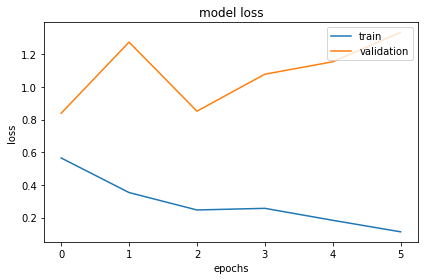

In [5]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.1,patience=5,verbose = 1)
# early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss',verbose=1, patience= 5)

opt_nadam = tf.keras.optimizers.Adam(1e-4)#Adam with Nestrov momentum

model.compile(optimizer= opt_nadam, loss=loss_function,metrics = [tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

#Initilaising the model
history = model.fit(train_data_generator, steps_per_epoch=len(train_data_generator.classes)//batch_size, validation_data = val_data_generator,epochs = epoch,class_weight = weights,callbacks =[es,reduce_lr],workers = 4)
    
plt_history(history)#model_loss_plot 

Evaluation on Validation data

In [6]:
AVG_LIST_PREDICTIONS_VAL = []
MAX_LIST_PREDICTIONS_VAL = []
y_val_labels= []
print("Prediction on validation data using aggregation method")
for path, subdirs, files in os.walk(val_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        if "Epithelioid" in path:
          y_val_labels.append(0.0)
        elif "Nonepithelioid" in path:
          y_val_labels.append(1.0) 

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS_VAL.append(avg(predictions))
        MAX_LIST_PREDICTIONS_VAL.append(max(predictions))

Prediction on validation data using aggregation method


AUC - ROC on validation data average prediction scores: 0.83125
-----------------------------------------------------


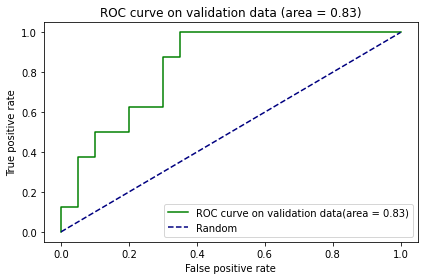

In [7]:
false_pr_avg,true_pr_avg,threshold = roc_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
roc_auc_avg = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on validation data average prediction scores:",roc_auc_avg)
print("-----------------------------------------------------")
plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

AUC - ROC on validation data maximum prediction scores: 0.76875
-----------------------------------------------------


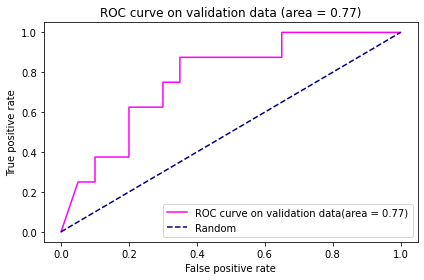

In [8]:
false_pr_max,true_pr_max,threshold = roc_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
roc_auc_max = auc(false_pr_max,true_pr_max)
print("AUC - ROC on validation data maximum prediction scores:",roc_auc_max)
print("-----------------------------------------------------")
plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

Presicion - Recall auc on validation data average score predictions: 0.6207434926184926
-----------------------------------------------------


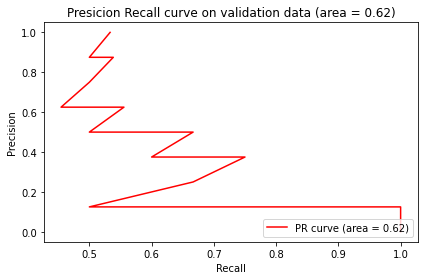

Presicion - Recall auc on validation data maximum score predictions: 0.5665310384060385
-----------------------------------------------------


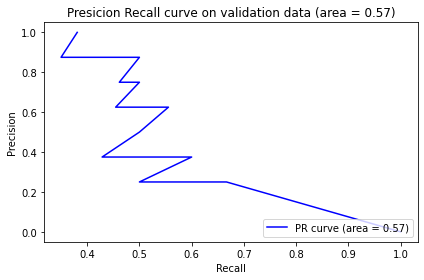

In [9]:
#presicion - recall curve
precision, recall, threshold = precision_recall_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data average score predictions:",auc(recall,precision))
 
print("-----------------------------------------------------")
plt.plot(precision, recall,color='red',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall,precision)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

precision_max, recall_max, threshold = precision_recall_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data maximum score predictions:",auc(recall_max,precision_max))
print("-----------------------------------------------------")
plt.plot(precision_max, recall_max,color='blue',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [10]:
import sklearn
#classification report on average prediction values
AVG_LIST_PREDICTIONS_VAL = [round(x) for x in AVG_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,AVG_LIST_PREDICTIONS_VAL))

print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")

#classification report on maximum prediction values
MAX_LIST_PREDICTIONS_VAL = [round(x) for x in MAX_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,MAX_LIST_PREDICTIONS_VAL))

CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.83      0.75      0.79        20
         1.0       0.50      0.62      0.56         8

    accuracy                           0.71        28
   macro avg       0.67      0.69      0.67        28
weighted avg       0.74      0.71      0.72        28

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.29      1.00      0.44         8

    accuracy                           0.29        28
   macro avg       0.14      0.50      0.22        28
weighted avg       0.08      0.29      0.13        28



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation on Test Set

In [11]:
AVG_LIST_PREDICTIONS = []
MAX_LIST_PREDICTIONS = []
y_test_labels= []
print("Prediction on test using aggregation method")
for path, subdirs, files in os.walk(test_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        y_labels(path)

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS.append(avg(predictions))
        MAX_LIST_PREDICTIONS.append(max(predictions))

Prediction on test using aggregation method


AUC - ROC on Test data average prediction scores: 0.4
-----------------------------------------------------


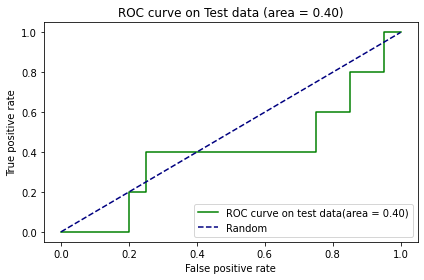

AUC - ROC on Test data maximum prediction scores: 0.43000000000000005
-----------------------------------------------------


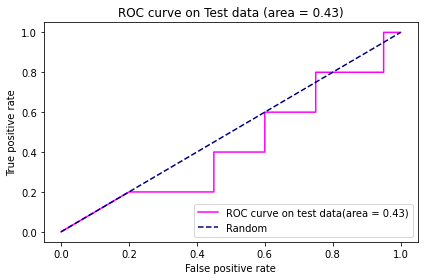

In [12]:
prediction_scores(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS)

Presicion - Recall auc on test data average score predictions: 0.1659417245158933
-----------------------------------------------------


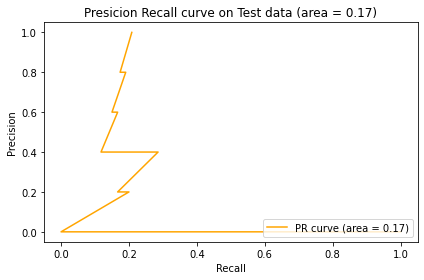

Presicion - Recall auc on test data maximum score predictions: 0.2584114683943059
-----------------------------------------------------


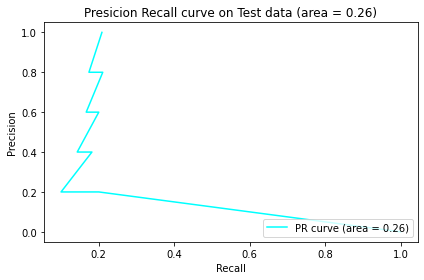

In [13]:
pre_recall(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS)

In [14]:
from sklearn.metrics import classification_report
AVG_LIST_PREDICTIONS = [round(x) for x in AVG_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT")
print(classification_report(y_test_labels,AVG_LIST_PREDICTIONS))

print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")

MAX_LIST_PREDICTIONS = [round(x) for x in MAX_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT for MAX VALUE PREDICTIONS")
print(classification_report(y_test_labels,MAX_LIST_PREDICTIONS))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.82      0.70      0.76        20
         1.0       0.25      0.40      0.31         5

    accuracy                           0.64        25
   macro avg       0.54      0.55      0.53        25
weighted avg       0.71      0.64      0.67        25

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
CLASSIFICATION REPORT for MAX VALUE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.20      1.00      0.33         5

    accuracy                           0.20        25
   macro avg       0.10      0.50      0.17        25
weighted avg       0.04      0.20      0.07        25



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
#creating a datframe to save predictions with actuals
df = pd.DataFrame()
df['Average'] = AVG_LIST_PREDICTIONS
df['Maximum'] = MAX_LIST_PREDICTIONS
df['Actual labels'] = y_test_labels
#saving into csv file for futher use
df.to_csv('FOLD2_2000_res34_test_1e-4.csv',index = False,header = True)
!cp FOLD2_2000_res34_test_1e-4.csv "drive/My Drive/"

In [16]:
#creating a datframe to save predictions with actuals
df_val = pd.DataFrame()
df_val['Average'] = AVG_LIST_PREDICTIONS_VAL
df_val['Maximum'] = MAX_LIST_PREDICTIONS_VAL
df_val['Actual labels'] = y_val_labels
#saving into csv file for futher use
df_val.to_csv('FOLD2_2000_res34_val_1e-4.csv',index = False,header = True)
!cp FOLD2_2000_res34_val_1e-4.csv "drive/My Drive/"

In [17]:
#saving the model
model.save("fold2_resnet34_2000_1e-4.h5")
!cp fold2_resnet34_2000_1e-4.h5 "drive/My Drive/"